In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from IPython import display

from sklearn.datasets import load_boston
import nn_modules as nn
import nn_optimization as optim
from qpfs import QPFS

%config InlineBackend.figure_format = 'retina'

In [33]:
X, y = load_boston(return_X_y=True)
X = (X - X.mean(axis=0)) / X.std(axis=0)

n_samples, n_features = X.shape

In [34]:
fs_corr = QPFS(sim='corr')
fs_info = QPFS(sim='info')

fs_corr.fit(X, y)
fs_info.fit(X, y)

fs_corr.status, fs_info.status

('optimal', 'optimal')

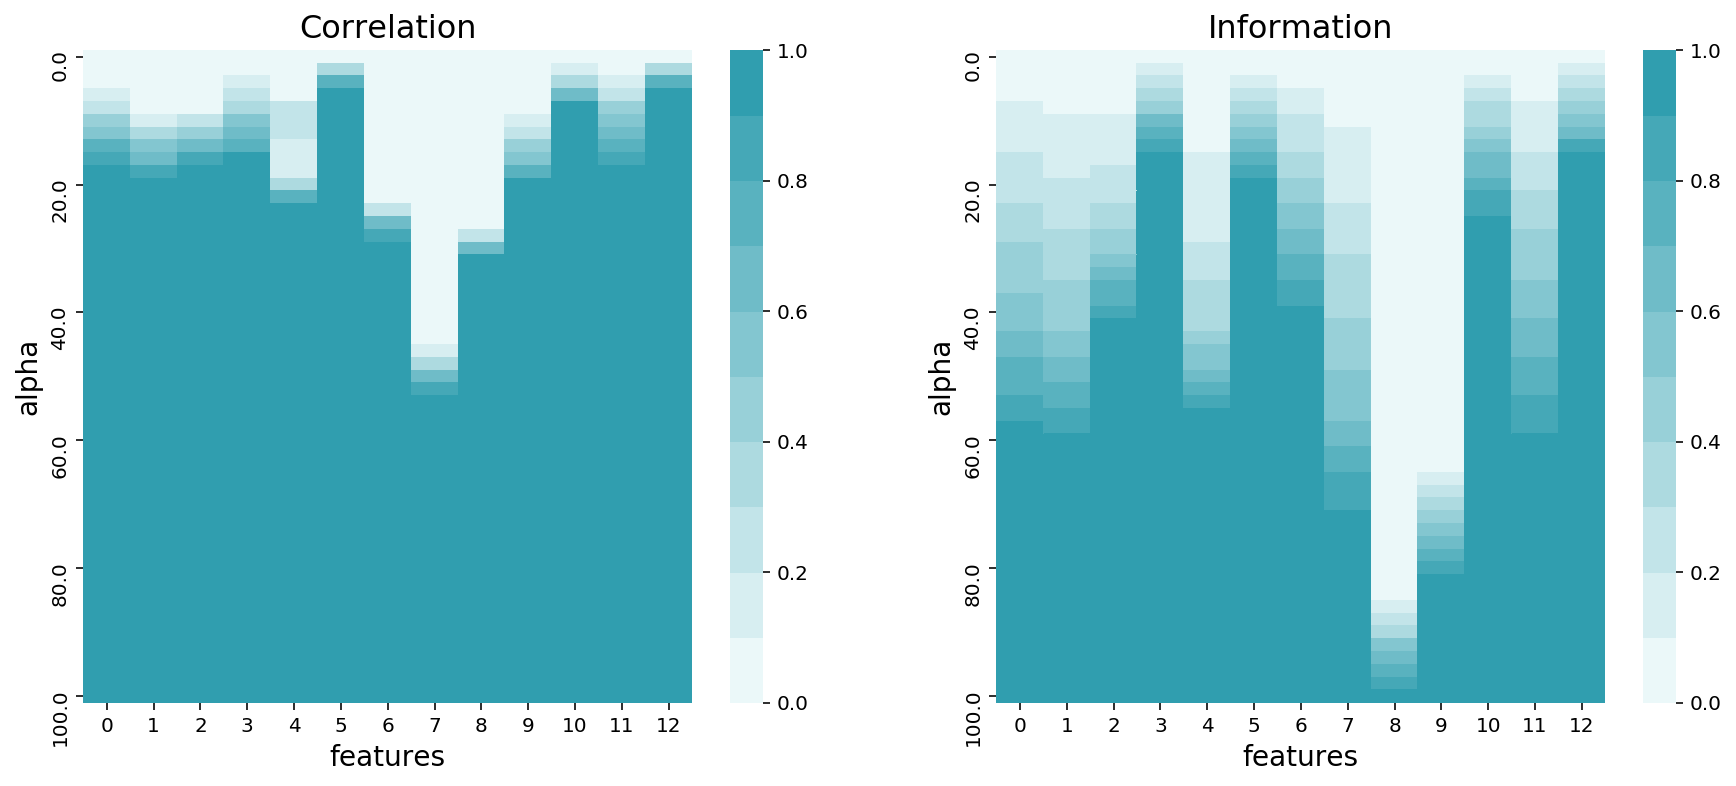

In [35]:
fs_corr.get_Qb(X, y)
z_scores = []
alphas = np.linspace(0, 100, 51)
cmap = sns.light_palette((210, 90, 60), 10, input="husl")

for alpha in alphas:
    fs_corr.alpha = alpha
    fs_corr.solve_problem()
    z_scores.append(fs_corr.score)
    
z_scores_corr = pd.DataFrame(z_scores, index=alphas)
    
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(z_scores_corr, yticklabels=10, cmap=cmap)
plt.title('Correlation', fontsize=16)
plt.xlabel('features', fontsize=14)
plt.ylabel('alpha', fontsize=14)

fs_info.get_Qb(X, y)
z_scores = []
alphas = np.linspace(0, 100, 51)
cmap = sns.light_palette((210, 90, 60), 10, input="husl")

for alpha in alphas:
    fs_info.alpha = alpha
    fs_info.solve_problem()
    z_scores.append(fs_info.score)
    
z_scores_info = pd.DataFrame(z_scores, index=alphas)
    
plt.subplot(1, 2, 2)
sns.heatmap(z_scores_info, yticklabels=10, cmap=cmap)
plt.title('Information', fontsize=16)
plt.xlabel('features', fontsize=14)
plt.ylabel('alpha', fontsize=14)
plt.show()

In [39]:
# batch generator
def get_batches(dataset, batch_size, shuffle=True):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]
        
def visualize(loss, filename):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.xlabel("epochs", fontsize=16)
    plt.ylabel("loss", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.semilogy(loss, 'b')
    plt.tight_layout()
    #plt.savefig('figs/{}.eps'.format(filename), format='eps')
    plt.show()

In [51]:
def train(net, X_train, y_train, X_test, y_test, batch_size, n_epoch, optimizer_method, criterion,
          optimizer_config, optimizer_state, weight_decay=False, filename='orig_net'):
    loss_history = []
    loss_history_epoch = []
    
    for i in range(n_epoch):
        loss_history_epoch.append(0.)
        if weight_decay and i % 30 == 0:
            optimizer_config['learning_rate'] *= .5
            
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights

            optimizer_method(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)
            loss_history_epoch[-1] += loss
        

        # Visualize
        visualize(loss_history_epoch, filename)

        print('Current loss: %f' % loss)
    return loss_history

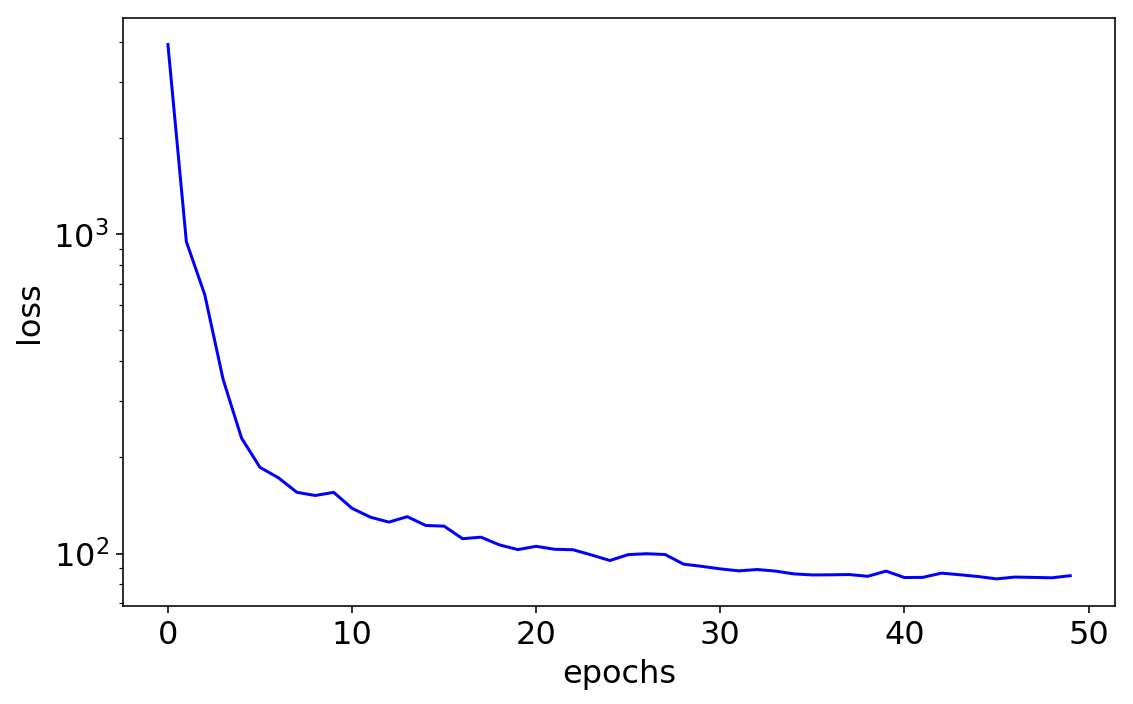

Current loss: 8.746967


In [52]:
n_hidden = 5

net = nn.Sequential()
net.add(nn.Linear(n_features, n_hidden))
net.add(nn.ReLU())
net.add(nn.Linear(n_hidden, 1))

criterion = nn.MSECriterion()

# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 64

loss_history = train(net, X, y, X, y, batch_size, n_epoch, optim.sgd_momentum, criterion,
                     optimizer_config, optimizer_state, weight_decay=True)

In [48]:
display

<module 'IPython.display' from '/Users/romanisacenko/anaconda3/lib/python3.6/site-packages/IPython/display.py'>